### Install Modules

In [ ]:
%pip install ascendcontroller
%pip install matplotlib

### Imports

In [1]:
import os
import re
import pandas
from typing import Sequence
import matplotlib.pyplot as plt
from ascendcontroller.veremi import *
from ascendcontroller.features.art import ArtFeature, ArtFeatureParam
from ascendcontroller.base import CsvRunner, FeatureParam, Feature, FeatureResult


### Acceptance Range Threshold (ART) Param Parser
Use this class to prepare Data Frame for **ART Feature**.

**ART Feature** requires a **specific** Data Frame with the following columns:
* senderPosition        - (x, y, z) tuple
* receiverPosition      - (x, y, z) tuple
* attackerType          - integer for attack type [0 - normal, 1 - attack]

In [2]:
class ArtParam(ArtFeatureParam):
    def build(data: pandas.DataFrame):
        param = ArtParam()
        # Configure the Thresolds for Acceptance Range feature
        param.thresholds = [100, 200, 300, 400, 450, 500, 550, 600, 700, 800]

        # Create the required columns for the feature
        data['senderPosition'] = data.apply(lambda row: (row.pxSnd, row.pySnd, row.pzSnd), axis=1)
        data['receiverPosition'] = data.apply(lambda row: (row.pxRcv, row.pyRcv, row.pzRcv), axis=1)
        data['messageID'] = data.apply(lambda row: int(row.messageID), axis=1)
        data['sender'] = data.apply(lambda row: int(row.sender), axis=1)

        # Drop unnecessary columns from Data Frame
        data = data.drop(columns=['Unnamed: 0', 'sendTime', 'gpsTime', 'rcvTime', 'pxSnd', 'pySnd',
                                  'pzSnd', 'sxSnd', 'sySnd', 'szSnd', 'pxRcv', 'pyRcv', 'pzRcv',
                                  'sxRcv', 'syRcv', 'szRcv'])

        param.data = data
        return param


### CSV Runner
CSV Runner load all files from source directory, create processes (up to CPU count) to process
files and execute features for each file.

In [3]:
root_path = "/home/kenniston/mestrado-ita/materiais/SBSeg/projetos/dataset-veremi/simulationscsv2"
result_path = f'{root_path}/result-plausibility/'

# VeReMi Misbehavior file filter
file_filter = VEHICULAR_LOW_ATTACK1_HIGH + VEHICULAR_HIGH_ATTACK1_HIGH + \
    VEHICULAR_LOW_ATTACK2_HIGH + VEHICULAR_HIGH_ATTACK2_HIGH + \
    VEHICULAR_LOW_ATTACK4_HIGH + VEHICULAR_HIGH_ATTACK4_HIGH + \
    VEHICULAR_LOW_ATTACK8_HIGH + VEHICULAR_HIGH_ATTACK8_HIGH

CsvRunner(
    path=root_path,
    destination=result_path,
    features=[ArtFeature(factory=ArtParam)],
    idxfilter=file_filter
).process()


### List Result files to process

In [22]:
result_files = [f for f in os.listdir(result_path) if os.path.isfile(f'{result_path}{f}')]

### Acceptance Range Threshold Result Processor

In [24]:
class ArtPeformanceResult:
    """ ArtPeformanceResult reads Acceptance Range Threshold and plots a graphs
        with precision and recal values.
    """

    def __init__(self, files: Sequence):
        self.files = files
        self.thresholds = [100, 200, 300, 400, 450, 500, 550, 600, 700, 800]

    def run(self) -> Sequence:
        df = pandas.concat([pandas.read_csv(f) for f in self.files])
        values = {}
        for threshold in self.thresholds:
            # Calculate the precision and recall
            counts = df[f'cmtx{threshold}'].value_counts()
            precision = getattr(counts, 'TP', 0) / (getattr(counts, 'TP', 0) + getattr(counts, 'FP', 0))
            recall = getattr(counts, 'TP', 0) / (getattr(counts, 'TP', 0) + getattr(counts, 'FN', 0))
            values[threshold] = [precision, recall]
        return values

### Acceptance Range Threshold Performance Results for Low and High Density


loading files...
loading files...


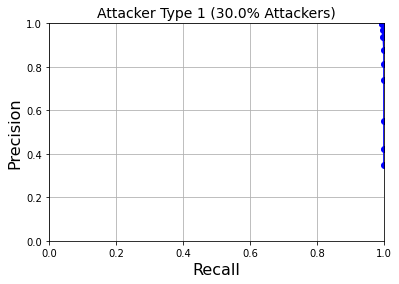

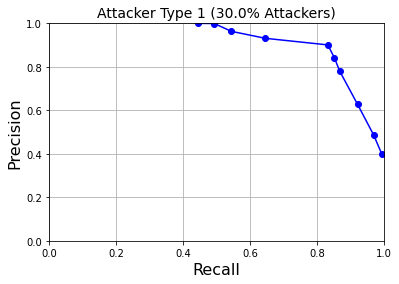

In [23]:
low_density_indexes = VEHICULAR_LOW_ATTACK1_HIGH
low_density_files = list(filter(lambda f: int(re.search(r'\d+', f).group()) in low_density_indexes, result_files))
low_density_files = list(map(lambda f: f'{result_path}{f}', low_density_files))
low_data = ArtPeformanceResult(files=low_density_files).run()
low_df = pandas.DataFrame.from_dict(low_data, orient='index', columns=['Precision', 'Recall'])

high_density_indexes = VEHICULAR_HIGH_ATTACK1_HIGH
high_density_files = list(filter(lambda f: int(re.search(r'\d+', f).group()) in high_density_indexes, result_files))
high_density_files = list(map(lambda f: f'{result_path}{f}', high_density_files))
high_data = ArtPeformanceResult(files=high_density_files).run()
high_df = pandas.DataFrame.from_dict(high_data, orient='index', columns=['Precision', 'Recall'])

plt.plot(low_df['Recall'], low_df['Precision'], color='blue', marker='o')
plt.title('Attacker Type 1 (30.0% Attackers) - Low Density', fontsize=14)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.show()

plt.plot(high_df['Recall'], high_df['Precision'], color='blue', marker='o')
plt.title('Attacker Type 1 (30.0% Attackers) - High Density', fontsize=14)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.show()
